### All Users: Dev Environment

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

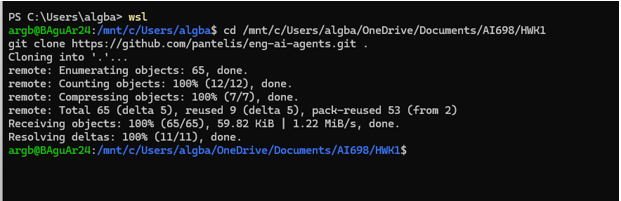

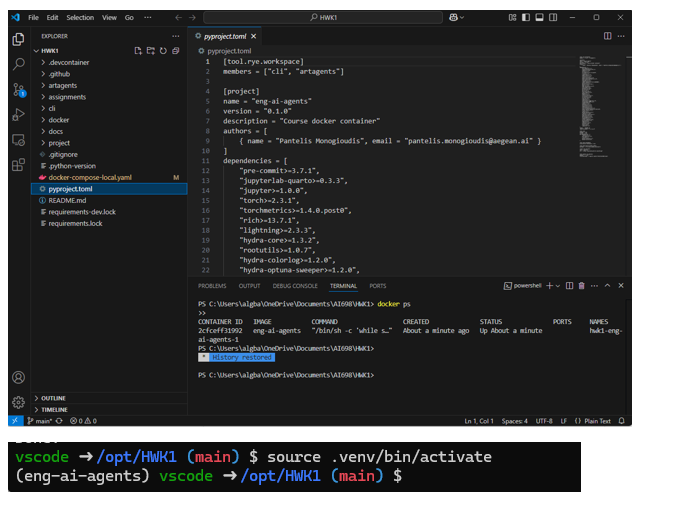

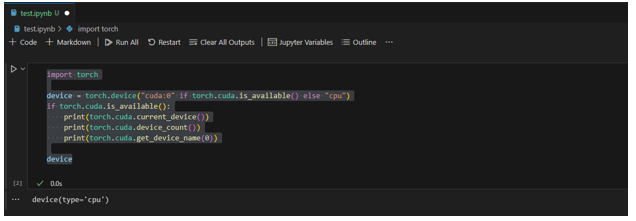

### Custom Torchvision dataset

Process the video. Note that you can sample the video to generate 1000 images total. 
You can use yt-dlp or other tools for downloading the video.

In [ ]:
import cv2
import os
import numpy as np

# Path to the video file
video_path = 'C:/Users/algba/OneDrive/Documents/AI698/HWK1/video_files_hwk1/Cyclist and vehicle Tracking - 1 [WeF4wpw7w9k].mp4'

# Path where frames will be stored
output_path = 'C:/Users/algba/OneDrive/Documents/AI698/HWK1/video_files_hwk1/frames/frame_%04d.png'

# Open video file
cap = cv2.VideoCapture(video_path)

# Total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Evenly sampling
step = total_frames // 1000

# Extract 1000 evenly spaced frames
frame_count = 0
for i in range(1000):
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
    
    # Read the frame
    ret, frame = cap.read()
    
    if ret:
        # Save the frame as a PNG file
        cv2.imwrite(output_path % (frame_count), frame)
        frame_count += 1
    else:
        print(f"Frame {i} could not be read.")
        break

cap.release()
print(f"1000 frames extracted to {os.path.dirname(output_path)}")


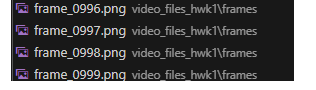

In [ ]:
#### Calculate the mean and standard deviation

import torch
from torchvision import transforms
from PIL import Image
import os

# Path to the frames directory
frames_dir = 'C:/Users/algba/OneDrive/Documents/AI698/HWK1/video_files_hwk1/frames'

# Define a transformation that only converts the image to a tensor
transform = transforms.ToTensor()

# Initialize variables to calculate mean and std
mean = 0.0
std = 0.0
num_samples = 0

# Iterate over the dataset
for img_name in os.listdir(frames_dir):
    if img_name.endswith('.png'):  # We only want .png images
        img_path = os.path.join(frames_dir, img_name)
        image = Image.open(img_path)
        image_tensor = transform(image)
        
        # Update mean and std
        mean += image_tensor.mean([1, 2])  # Mean across the height and width
        std += image_tensor.std([1, 2])  # Std across the height and width
        num_samples += 1

# Calculate the mean and std of the dataset
mean /= num_samples
std /= num_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

mean = [0.3842, 0.3537, 0.3248]
std = [0.2612, 0.1940, 0.1626]

In [ ]:
#### Custom Dataset

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# Custom Dataset class
class VideoFrameDataset(Dataset):
    def __init__(self, frames_dir, transform=None):
        self.frames_dir = frames_dir
        self.transform = transform
        self.frame_files = [f for f in os.listdir(frames_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.frames_dir, self.frame_files[idx])
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image

# pre-calculated mean and std
mean = [0.3842, 0.3537, 0.3248]
std = [0.2612, 0.1940, 0.1626]

# Apply the transformations (resize, to tensor, normalize using the calculated mean and std)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize using the calculated mean and std
])

# Create the dataset and dataloader
frames_dir = 'C:/Users/algba/OneDrive/Documents/AI698/HWK1/video_files_hwk1/frames'
dataset = VideoFrameDataset(frames_dir=frames_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
import fiftyone as fo
print(fo.__version__)


import fiftyone as fo
print(fo.config.database_uri)  # return a valid MongoDB URI

### Visualization

import fiftyone as fo
import os

# Define the path to your images
frames_dir = 'C:/Users/algba/OneDrive/Documents/AI698/HWK1/video_files_hwk1/frames'

# Initialize a list to hold sample data
samples = []

# Create samples for each image in your dataset
for img_name in os.listdir(frames_dir):
    if img_name.endswith('.png'):
        img_path = os.path.join(frames_dir, img_name)
        sample = {
            "filepath": img_path,  # Path to the image
            "label": img_name,  # Use the image filename as a label (optional)
        }
        samples.append(sample)

# Use a unique dataset name
dataset = fo.Dataset(name="video_frames_unique")

# Add samples to the dataset
for sample in samples:
    sample_obj = fo.Sample(filepath=sample["filepath"])
    sample_obj["label"] = sample["label"]
    dataset.add_sample(sample_obj)

# Launch the FiftyOne app to visualize the dataset
session = fo.launch_app(dataset)